In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
df = pd.read_csv('example_wp_log_peyton_manning.csv')

In [4]:
m = Prophet()
m.fit(df)

INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
# Up to this point, we have used the entire time series and as such we need to split into a training and test set to validate our model
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days',period='180 days',horizon='365 days')

INFO - Making 11 forecasts with cutoffs between 2010-02-15 00:00:00 and 2015-01-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [6]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.955064,8.480612,9.446989,8.242493,2010-02-15
1,2010-02-17,8.721462,8.238617,9.181408,8.008033,2010-02-15
2,2010-02-18,8.605128,8.095479,9.131033,8.045268,2010-02-15
3,2010-02-19,8.526949,8.013201,9.030890,7.928766,2010-02-15
4,2010-02-20,8.268824,7.791901,8.791790,7.745003,2010-02-15


In [7]:
#Specify the custom cutoff as every 6 months
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
"""
The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the yhat_lower and yhat_upper estimates.
"""
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.493765,0.702684,0.504584,0.058462,0.049877,0.058757,0.681590
1,38 days,0.499582,0.706811,0.509580,0.059040,0.049518,0.059395,0.681590
2,39 days,0.521696,0.722286,0.515672,0.059640,0.049715,0.060120,0.680219
3,40 days,0.528906,0.727259,0.518442,0.059935,0.049375,0.060484,0.681361
4,41 days,0.536318,0.732337,0.519362,0.060005,0.049518,0.060618,0.688899


C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\DW814QU\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



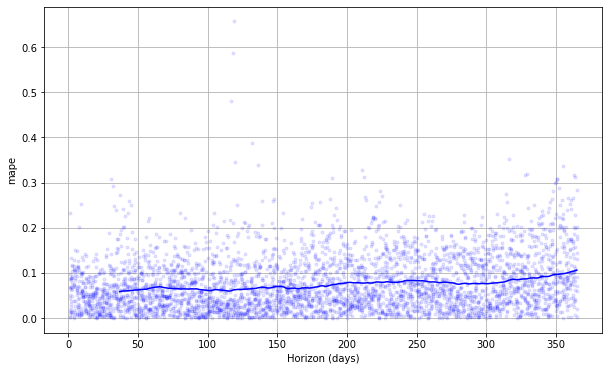

In [9]:
#The percentage of errors increase from roughly 5 to 10% from 1 month to 12 months out
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
#Dask can be used for larger problems which require distributed computing
"""
from dask.distributed import Client

client = Client()  # connect to the cluster

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',

                         parallel="dask")
"""

In [10]:
#Iterate over change point and seasonlity to tune the hyperparameters
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023EBBE74F60>
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023EBB322160>
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023EBB2F4320>
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000023EBBEA3A20>
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor objec

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.757632
1                     0.001                     0.10  0.743744
2                     0.001                     1.00  0.752994
3                     0.001                    10.00  0.753205
4                     0.010                     0.01  0.525074
5                     0.010                     0.10  0.540450
6                     0.010                     1.00  0.521752
7                     0.010                    10.00  0.542099
8                     0.100                     0.01  0.523994
9                     0.100                     0.10  0.518594
10                    0.100                     1.00  0.519576
11                    0.100                    10.00  0.521140
12                    0.500                     0.01  0.530504
13                    0.500                     0.10  0.527880
14                    0.500                     1.00  0

In [11]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [12]:
#Save the model to JSON
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

In [13]:
m = Prophet(growth='flat')

In [15]:
#The model can be updated and fit slightly faster for small updates if "warm-started" (e.g. an extra day is added)

def stan_init(m):
    """Retrieve parameters from a trained model.
    
    Retrieve parameters from a trained model in the format
    used to initialize a new Stan model.
    
    Parameters
    ----------
    m: A trained model of the Prophet class.
    
    Returns
    -------
    A Dictionary containing retrieved parameters of m.
    
    """
    res = {}
    for pname in ['k', 'm', 'sigma_obs']:
        res[pname] = m.params[pname][0][0]
    for pname in ['delta', 'beta']:
        res[pname] = m.params[pname][0]
    return res

df = pd.read_csv('example_wp_log_peyton_manning.csv')
df1 = df.loc[df['ds'] < '2016-01-19', :]  # All data except the last day
m1 = Prophet().fit(df1) # A model fit to all data except the last day


%timeit m2 = Prophet().fit(df)  # Adding the last day, fitting from scratch
%timeit m2 = Prophet().fit(df, init=stan_init(m1))  # Adding the last day, warm-starting from m1

INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


5.61 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


298 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
